###  Numerical Linear Algebra course (Homework 1)
#### Student: Abramov Semen
#### Skoltech, 11.11.2018

# Problem Set 1 (120 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

Read [homework rules](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf) carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>

# Problem 1 (Python demo) 40 pts

## Data preparation (10 pts)

* First of all download $\verb|.wav|$ file with starcraft sound from [here](https://github.com/oseledets/nla2018/tree/master/psets). Load it in python and play using the following functions:

In [48]:
from scipy.linalg import toeplitz
import numpy as np
import math
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib notebook

<IPython.core.display.Javascript object>


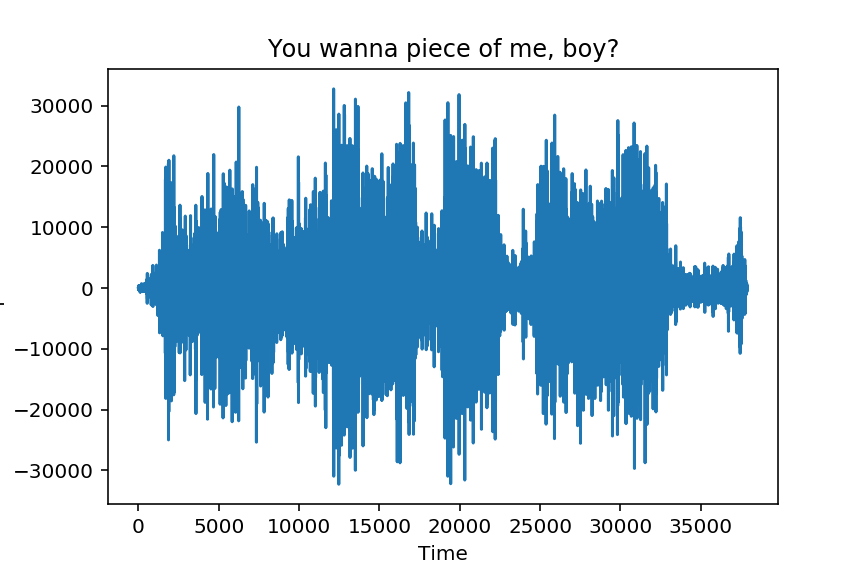

In [49]:
# reading
rate, audio = wav.read("TMaRdy00.wav")

# plotting
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

# playing
Audio(audio, rate=rate)

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* (5 pts) Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 

I have 16 gb memory, but for normal performance I don't want to fill all available RAM. So, let's assume that for matrix storage I want to take 8 gb.
We have float64 type in numpy array, that is in my system 8 bytes. So, it leads to the next calculation

In [52]:
N = np.sqrt((8 * 2**10 * 2**10 * 2**10)/8)
print("N =",N)
print("Original signal size:", audio.size)
# To save signal in 8 gb RAM I will cat second number in array
signal = audio[::2]
N = signal.size

N = 32768.0
Original signal size: 37888


* (5 pts) Write a function 
```python
def gen_toeplitz(N, alpha):    
    return T
```
that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. <font color='red'> Avoid using loops or lists! </font> The function [np.meshgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) will be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $$y_i = \sum_{j=1}^N T_{i-j} x_j.$$ Convolutions can be computed faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

In [53]:
# INPUT: N - integer (positive), alpha - float (positive)
# OUTPUT: T - np.array (shape: NxN)

def gen_toeplitz(N, alpha):
    i, j = np.meshgrid(np.arange(1, N+1, 1), np.arange(1, N+1, 1))
    T = np.power(np.exp(-alpha), (i - j)**2) * np.sqrt(alpha/math.pi)
    return T

## Convolution (10 pts)

* (5 pts) Write a function ```convolution``` (see below)
that takes the signal you want to convolve and multiply it by Toeplitz matrix T (for matvec operations use @ symbol). 

In [5]:
# INPUT: signal - np.array (shape: Nx1), N - int (positive), alpha - float (positive)
# OUTPUT: convolved_signal - np.array (shape: Nx1)

def convolution(signal, N, alpha):
    T = gen_toeplitz(N, alpha)
    convolved_signal = T @ signal.T
    return convolved_signal

* (3 pts) Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Each subplot should contain first $100$ points of initial and convolved signals for some $\alpha$. Make sure that you got results that look like smoothed initial signal.

* (2 pts) Play the resulting signal. In order to do so you should also scale the frequency (rate), which is one of the inputs in `Audio`.  
Note that you cannot play a signal which is too small.

In [54]:
conv_signal_0 = convolution(signal, N, 1/5)
conv_signal_1 = convolution(signal, N, 1/100)

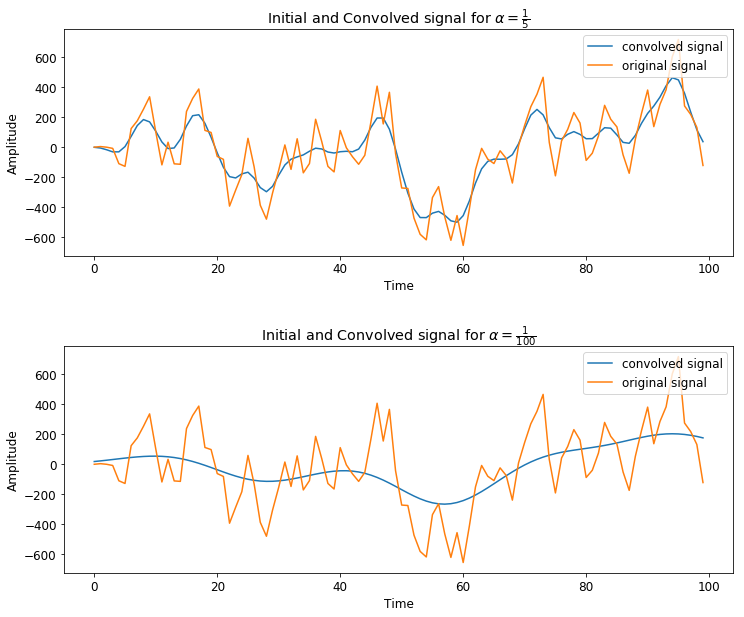

In [320]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
plt.plot(conv_signal_0[0:100], label="convolved signal")
plt.plot(signal[0:100], label="original signal")
plt.title(r'Initial and Convolved signal for $ \alpha = \frac{1}{5} $')
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.legend(loc = "upper right")

plt.subplot(2, 1, 2)
plt.plot(conv_signal_1[0:100], label="convolved signal")
plt.plot(signal[0:100], label="original signal")
plt.title(r'Initial and Convolved signal for $ \alpha = \frac{1}{100} $')
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.legend(loc = "upper right")
plt.show()

For initial signal

In [104]:
Audio(signal, rate=rate/2)

For convolved signal with $\alpha = \frac{1}{5}$

In [105]:
Audio(conv_signal_0, rate=rate/2)

For convolved signal with $\alpha = \frac{1}{100}$

In [106]:
Audio(conv_signal_1, rate=rate/2)

## Deconvolution (20 pts)

Given a convolved signal $y$ and an initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$, we can consider the following. Let us note that if $x_k$ converges to some limit $x$, then so does $x_{k+1}$. Taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process requires only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* (5 pts) For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is a derivation of $\tau_k$. The parameter $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

Using 
$$ x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots $$
derive
$$
    r_{k+1} = Tx_{k+1} - y = T(x_{k} - \tau_k (Tx_k - y)) - y = r_{k} - \tau_k Tr_{k}
$$
We need to minimize $ L_{2} $ norm 
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k} 
$$
$$
    \|r_{k+1}\|_2 = \sqrt  {\langle r_{k+1},r_{k+1} \rangle}
$$
$$
    \langle r_{k+1},r_{k+1} \rangle = \langle r_{k},r_{k} \rangle - 2\tau_k\langle Tr_{k},r_{k} \rangle + \tau_k ^{2} \langle Tr_{k},Tr_{k} \rangle
$$

To minimize the norm we need it's derivative by parameter $ \tau_k $ to be equal to zero, so derivative of $ \langle r_{k+1},r_{k+1} \rangle $:

$$
    -2\langle Tr_{k},r_{k} \rangle + 2\tau_k\langle Tr_{k},Tr_{k} \rangle = 0
$$

$$
    \tau_k = \frac{\langle Tr_{k},r_{k} \rangle}{\langle Tr_{k},Tr_{k} \rangle}
$$

* (10 pts) Write a function ```iterative```
that outputs accuracy –– a numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|_2}{\|x\|_2}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. **Note:** The only loop you are allowed to use here is a loop for $k$.

In [140]:
# INPUT:  N - int (positive), alpha - float (positive), num_iter - integer (positive), 
#  y - np.array (shape: Nx1, convolved signal), s - np.array (shape: Nx1, original signal)
# OUTPUT: rel_error - np.array size (num_iter x 1)

def iterative(N, num_iter, y, s, alpha):
    x = np.zeros((num_iter, s.shape[0]))
    T = gen_toeplitz(N, alpha)
    rel_error = np.zeros(num_iter)
    s_norm = np.linalg.norm(s, ord=2)
    rel_error[0] = np.linalg.norm(x[0] - s, ord=2)/s_norm
    
    for k in range(num_iter-1):
        r = T @ x[k] - y
        tau = np.dot(T@r,r)/np.dot(T@r,T@r)
        x[k+1] = x[k] - tau*(T@x[k] - y)
        rel_error[k+1] = np.linalg.norm(x[k+1] - s, ord=2)/s_norm
    
    return rel_error

* (2 pts) Set ```num_iter=1000```, ```x=s[::20]``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$.

In [152]:
num_iter = 1000
x = audio[::20]
alpha = 1/2
N = x.size
y = convolution(x, N, alpha)
rel_error_0 = iterative(N, num_iter, y, x, alpha)

alpha = 1/5
y = convolution(x, N, alpha)
rel_error_1 = iterative(N, num_iter, y, x, alpha)

<IPython.core.display.Javascript object>


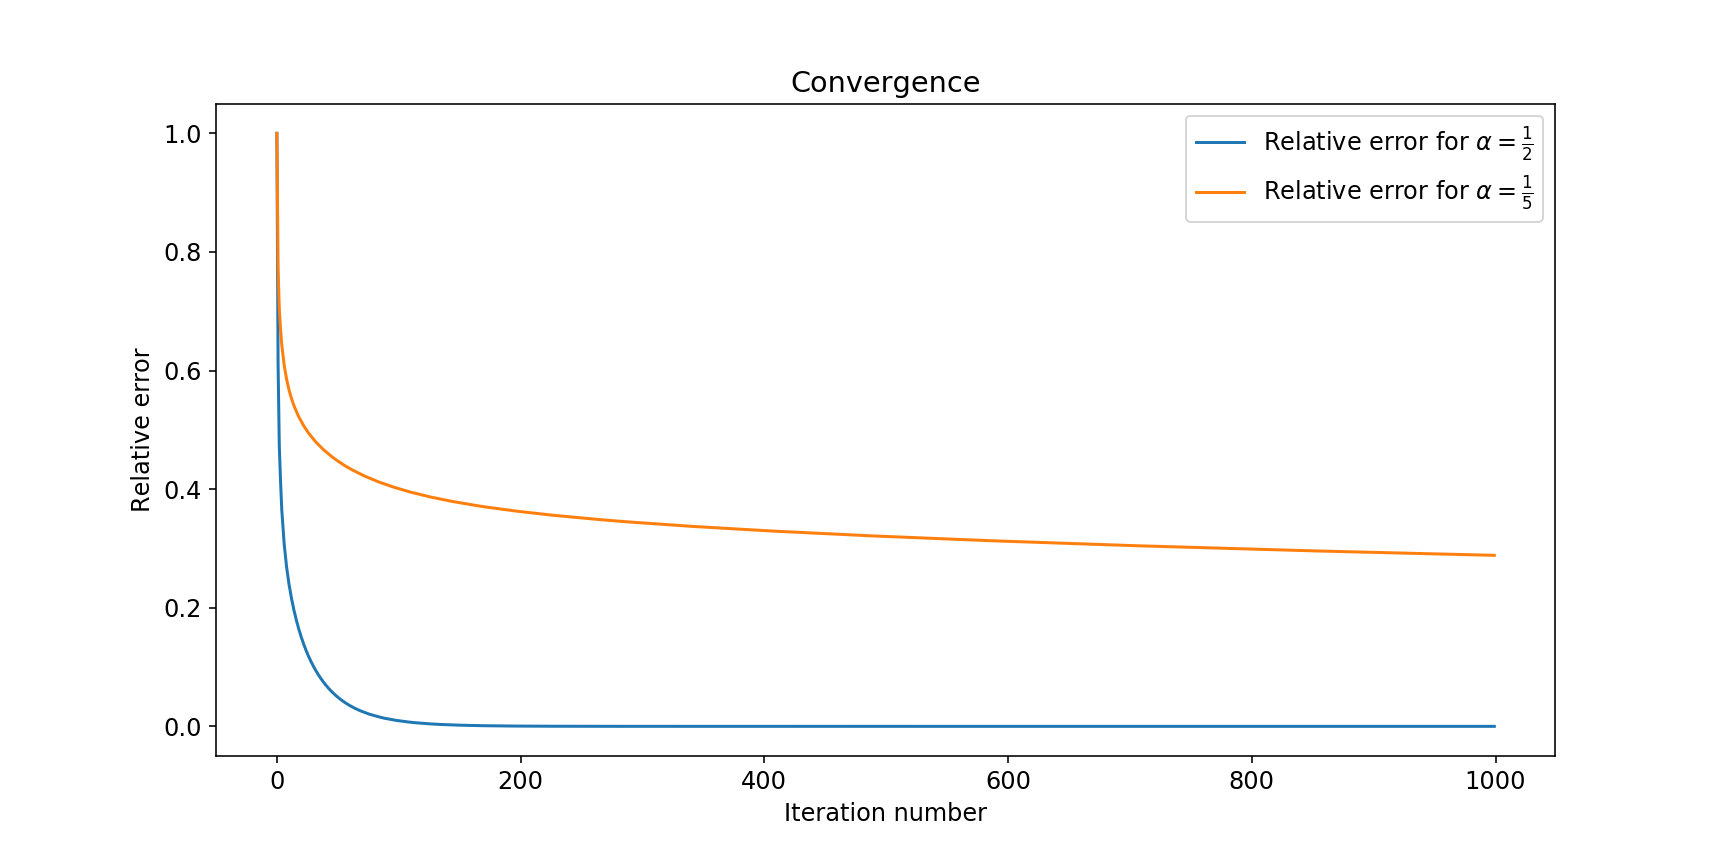

In [155]:
fig = plt.figure(figsize=(12, 6))
plt.rcParams['font.size'] = 12
plt.plot(rel_error_0, label=r'Relative error for $\alpha = \frac{1}{2}$')
plt.plot(rel_error_1, label=r'Relative error for $\alpha = \frac{1}{5}$')
plt.ylabel("Relative error")
plt.xlabel("Iteration number")
plt.title("Convergence")
plt.legend(loc = "upper right")
plt.show()

* (3 pts) Set ```x=s[::20]```, ```num_iter=1000``` and $\alpha=\frac{1}{5}$. Explain what happens with the convergence if you add small random noise of amplitude $10^{-3}\max(x)$  to $y$. The answer to this question should be an explanation supported by plots and/or tables.

In [150]:
x = audio[::20]
num_iter=1000
N = x.size
alpha = 1/5
conv_sign = convolution(x, N, alpha)
y =  conv_sign + 10**(-3) * np.random.uniform(low = -0.5, high = 0.5, size=x.size) * np.max(x)
rel_err = iterative(N, num_iter, y, x, alpha)

<IPython.core.display.Javascript object>


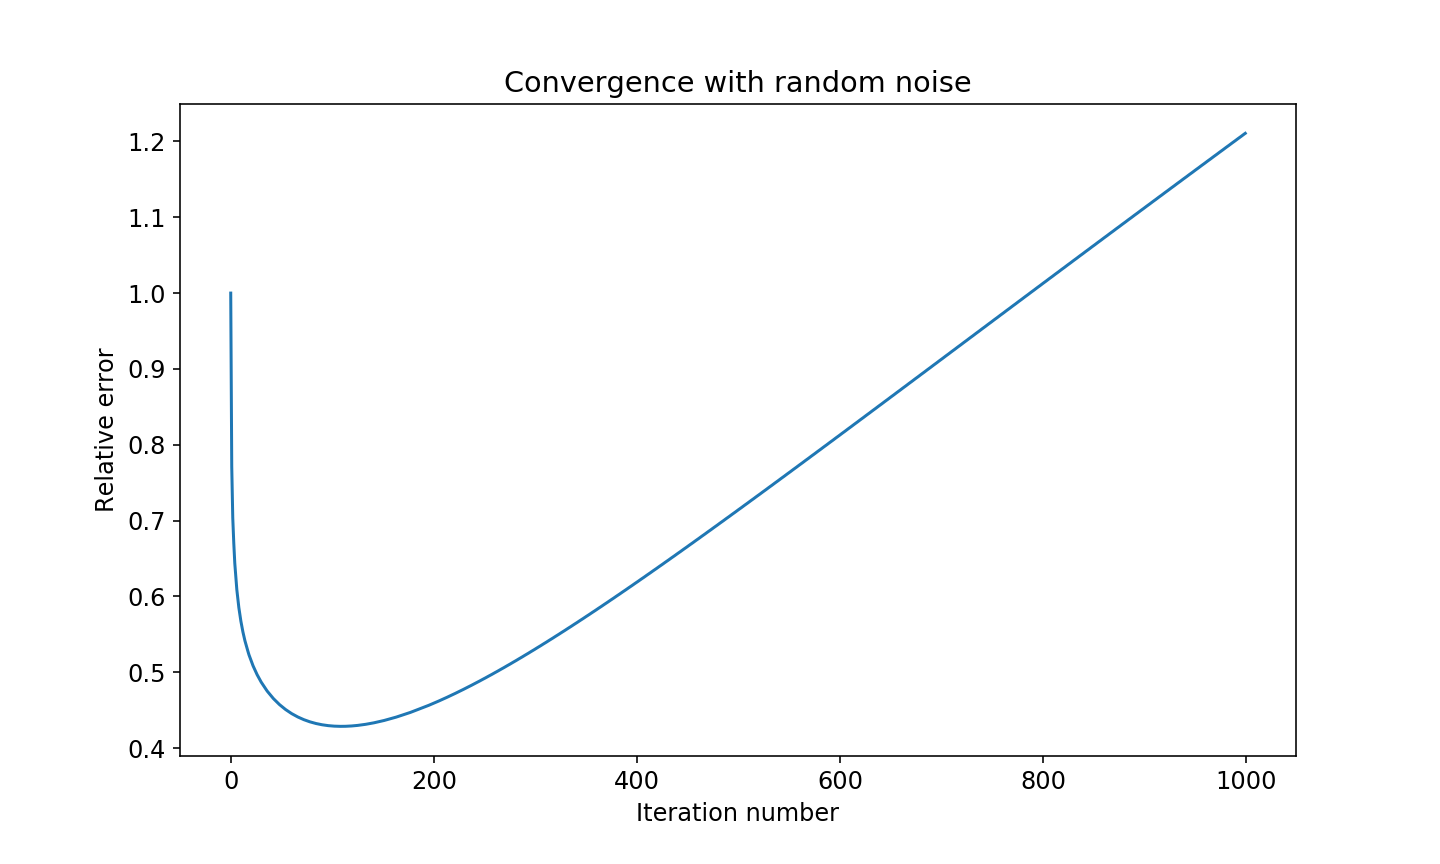

In [151]:
fig = plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12
plt.plot(rel_err)
plt.ylabel("Relative error")
plt.xlabel("Iteration number")
plt.title("Convergence with random noise")
plt.show()

According to iterative process $ x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots $, on each step we will try to reach the best approximation of signal $x$ choosing $\tau$ in a way to $\|Tx_{k+1} - y\|_2 \to \min_{\tau_k}$ When we will get randomly noised convolved signal, on the first steps we will really approximate signal $x$ because initial value $x_{0}$ is far from original and there is no any bias collected from random residual yet. After some point ("it will be a moment of best approximation") the relative error will increase continously, because on each iteration we are trying to get the best $\tau$ and construct approximation using randomly noised convolved signal. It is impossible, because the "direction of approximation" will change on every step randomly, so residual won't be minimized and iterative process will sum new bias from residual to $x_{k+1}$ on each step.

# Problem 2 (Theoretical tasks)  45 pts

_1._
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| Ux \|_2 = \| x \|_2$ for any $x$ iff $U$ is unitary.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary $U$.
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

_3._    
* (3 pts) Differentiate with respect to $A$ the function
$$
f(A) = \mathrm{sin}(x^\top A B C D x),
$$
where $x$ is a vector and $A, B, C, D$ are square matrices.

* (7 pts) Differentiate with respect to $y, A, X$ the function
$$f(y, A, X) = \mathrm{tr}(\mathrm{diag}(y) A X),$$
where $y \in \mathbb{R}^n$ and $A, X \in \mathbb{R}^{n \times n}$. Here 

$$
\mathrm{diag}(y)_{i, j} = 
    \begin{cases}
      y_i, & \text{if}\ i = j \\
      0, & \text{otherwise}
    \end{cases}
$$

#### Solutions

_1._
- Using fact from the lecture that $\|A\|_F^2 = \mathrm{trace}(A^*A)$ we can derive
$$\| U A \|_F^2 = \mathrm{trace}((UA)^*(UA)) = \mathrm{trace}(A^*U^*UA) = \mathrm{trace}(A^*A) = \| A \|_F^2$$     
And
$$\| A U \|_F^2 = \mathrm{trace}((AU)^*(AU)) = \mathrm{trace}(U^*A^*AU) = \mathrm{trace}(A^*A) = \| A \|_F^2$$
Since norm is non negative we proved the statement.


- Assume $$\| Ux \|_2 = \| x \|_2$$
Hence $\sqrt{\langle Ux,Ux \rangle} = \sqrt{\langle x,x \rangle}$
$$\sqrt{(Ux)^*(Ux)} = \sqrt{x^*x}$$
Since norm is non negative 
$$x^*U^*Ux = x^*x$$
$$x^*(U^*U - I)x = 0$$
So assumed equality $\| Ux \|_2 = \| x \|_2$ is right iff
$$(U^*U - I) = 0$$
Here we got a definition of unitary matrix 
$$U^*U = I_n$$
Where $U$ is a complex $n\times n$ square matrix.


- By definition of operator norm (class of matrix norms)from the lecture 
$$
    \Vert A \Vert_{*,**} = \sup_{x \ne 0} \frac{\Vert A x \Vert_*}{\Vert x \Vert_{**}}
$$
We proved above that $\| Ux \|_2 = \| x \|_2$ for for unitary matrix $U$. So, we have
$$
    \Vert A \Vert_2 = \sup_{x \ne 0} \frac{\Vert A x \Vert_2}{\Vert x \Vert_2} = \sup_{x \ne 0} \frac{\Vert U(A x) \Vert_2}{\Vert x \Vert_2} = \sup_{x \ne 0} \frac{\Vert (UA) x) \Vert_2}{\Vert x \Vert_2} = \| U A \|_2
$$
And
$$
    \| A U \|_2 =  \sup_{x \ne 0} \frac{\Vert (AU) x \Vert_2}{\Vert x \Vert_2} = \sup_{x \ne 0} \frac{\Vert (AU)(U^*x) \Vert_2}{\Vert (U^*x) \Vert_2} = \sup_{x \ne 0} \frac{\Vert Ax \Vert_2}{\Vert x \Vert_2} = \Vert A \Vert_2
$$


_2._
- Using theorem about SVD any matrix $A\in \mathbb{C}^{n\times m}$ can be written as $A = U \Sigma V^*$, where $U$ is an $n \times K$ unitary matrix, $V$ is an $m \times K$ unitary matrix, $K = \min(m, n)$, $\Sigma$ is a diagonal matrix with non-negative elements $\sigma_1 \geq  \ldots, \geq \sigma_K$ on the diagonal.
So $\| A \|_F = \| U \Sigma V^* \|_F = \| \Sigma \|_F$ and $\| A \|_2 = \| U \Sigma V^* \|_2 = \| \Sigma \|_2$, here we used property of unitary matrix's norm proved above.
So,
$$
    \| A \|_F = \| \Sigma \|_F = \sqrt{\sigma_{1}^2 + \dots + \sigma_{k}^2},
$$
where $k = rank(A)$
$$
    \| A \|_2 = \Vert \Sigma \Vert_2 = \sup_{x \ne 0} \frac{\Vert \Sigma x \Vert_2}{\Vert x \Vert_2} = \sigma_{1},
$$
because according SVD $\sigma$ is the highest singular value.
Since all $\sigma_{2}, \dots, \sigma{k}$ are not greater than $\sigma_{1}$, we have
$$
    \sqrt{\sigma_{1}^2 + \dots + \sigma_{k}^2} \le \sqrt{k}\sigma_{1}
$$
Hence, from the proved statements for $\| A \|_F = \| \Sigma \|_F = \sqrt{\sigma_{1}^2 + \dots + \sigma_{k}^2}$ and $\| A \|_2 = \Vert \Sigma \Vert_2 = \sigma_{1}$ we get
$$
    \| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2
$$


- To satisfy a condition $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$ we need to construct a matrix with $k$ equal singular values $\sigma_{1} = \dots = \sigma_{k}$. For any $m, n$ and $k \le \min(m, n)$ we can construct matrix A 
$$    
    \begin{bmatrix}
    a & 0 & 0 & \dots  &0 \\
    0 & a & 0 & \dots  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \dots  & 0
    \end{bmatrix},
$$
where we have element $a$ on "diagonal" k times. $ A^\top A $ gives $k$ equal singular values $\sigma = \sqrt{\lambda} = a$ So, we constructed matrix with $\mathrm{rank}(A) = k$ that gives $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$ 


- Using the fact about singular values (mentioned in lecture about SVD) that if $\text{rank}(A) = r$, then $\sigma_{r+1} = \dots = \sigma_K = 0$, where $K=min(m,n)$ for $A\in \mathbb{C}^{n\times m}$, for matrix with $\mathrm{rank}(A) = 1$ we have
$$ 
    \| A \|_F = \sqrt{\sigma_{1}^2 + \dots + \sigma_{k}^2} = \sqrt{\sigma_{1}^2} = \sigma_{1}
$$
And
$$
    \| A \|_2 = \sigma_{1}
$$
Proved
$$
    \| A \|_F = \| A \|_2
$$


- We can define $\| B \|_F^* = \sum_{i=1}^n b_i$, where $b_i$ is a column of $B$ ($B = \big[b_{1} \dots b_{n} \big]$). Since matrix 2 norm is consistent with a vector 2 norm: $ \| Ax \|_2 \le \| A \|_2 \|x\|_2$. So,
$$
    \| AB \|_F^2 = \sum_{i=1}^n \|Ab_i\|_2^2 \le \|A\|_2^2 \sum_{i=1}^n \|b_i\|_2^2 = \|A\|_2^2 \|B\|_F^2
$$
Proved $ \| AB \|_F \le \|A\|_2 \|B\|_F$


_3._
- 
$$
    \frac{\partial f(A)}{\partial A} = \mathrm{cos}(x^\top A B C D x) \frac{\partial (x^\top (A B C D) x)}{\partial A} = \mathrm{cos}(x^\top A B C D x) x x^\top \frac{\partial (A B C D)}{\partial A} = x x^\top BCD \mathrm{cos}(x^\top A B C D x)
$$


- Here we will use property of matrix trace
$$
    \mathrm{tr}(ABC) = \mathrm{tr}(BCA) = \mathrm{tr}(CAB)
$$
and differential identitie
$$
    d({\mathrm{tr}(A)}) = \mathrm{tr}(dA)
$$
Let's denote
$$
\mathrm{diag}(y)_{i, j} = 
    \begin{cases}
      y_i, & \text{if}\ i = j \\
      0, & \text{otherwise}
    \end{cases}
$$
as $Y$.                                                                                                          Derivative with respect to $X$
$$
    df(y, A, X) = d(\mathrm{tr}(\mathrm{diag}(y) A X)) = \mathrm{tr}(\mathrm{diag}(y) A dX)
$$
Hence
$$
    \frac{\partial f(y, A, X)}{\partial X} = (\mathrm{diag}(y) A)^\top = A^\top \mathrm{diag}(y)^\top = A^\top \mathrm{diag}(y)
$$
Derivative with respect to $A$
$$
    \frac{\partial f(y, A, X)}{\partial A} = \frac{\partial \mathrm{tr}(\mathrm{diag}(y) A X)}{\partial A} = \frac{\partial \mathrm{tr}(X \mathrm{diag}(y) A)}{\partial A} = (X\mathrm{diag}(y))^\top = \mathrm{diag}(y) X^\top
$$
Derivative with respect to $y$
$$
    f(y, A, X) = \mathrm{tr}(\mathrm{diag}(y) A X) = y_{1}z_{11} + \dots + y_{n}z_{nn},
$$
where $z_{11}, \dots, z_{nn}$ are diagonal elements of $AX$ matrix. Hence,
$$
    \frac{\partial f(y, A, X)}{\partial y} = \big(z_{11} \dots z_{nn}\big),
$$
where $z_{11}, \dots, z_{nn}$ are diagonal elements of $AX$ matrix.

# Problem 3 (Strassen algorithm) 15 pts

_1._ (3 pts) Implement the naive algorithm for squared matrix multiplication with explicit “for” cycles.

In [167]:
def naive_multiplication(A, B):
    """
    Implement naive matrix multiplication with explicit for cycles
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    C = np.zeros(A.shape)
    n = A.shape[0]
    m = A.shape[1]
    s = A.shape[1]
    
    for i in range(n):
        for j in range(m):
            for k in range(s):
                C[i,j] += A[i,k]*B[k,j]
    
    return C

_2._ (7 pts) Implement the Strassen algorithm.

In [170]:
def strassen(A, B):
    """
    Implement Strassen algorithm for matrix multiplication
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    n = A.shape[0]
    
    if (n <= 64):
        return naive_multiplication(A, B)
    
    # If matrix side is not power of two
    # we create padding on the first call
    # of strassen(A,B)
    
    next_power_of_two = lambda n: 2**int(math.ceil(math.log(n,2)))
    m = next_power_of_two(n)

    if (m != n):
        A_power_of_2 = np.zeros((m,m))
        B_power_of_2 = np.zeros((m,m))

        A_power_of_2[:-(m-n),:-(m-n)] = A
        B_power_of_2[:-(m-n),:-(m-n)] = B    
    else:
        A_power_of_2 = A
        B_power_of_2 = B
    
    k = int(m/2)
    
    A11 = A_power_of_2[:k, :k]
    A12 = A_power_of_2[:k, k:]
    A21 = A_power_of_2[k:, :k]    
    A22 = A_power_of_2[k:, k:]
    B11 = B_power_of_2[:k, :k]
    B12 = B_power_of_2[:k, k:]
    B21 = B_power_of_2[k:, :k]    
    B22 = B_power_of_2[k:, k:]
    

    F1 = strassen(A11 + A22, B11 + B22)
    F2 = strassen(A21 + A22, B11)
    F3 = strassen(A11, B12 - B22)
    F4 = strassen(A22, B21 - B11)
    F5 = strassen(A11 + A12, B22)
    F6 = strassen(A21 - A11, B11 + B12)
    F7 = strassen(A12 - A22, B21 + B22)
    
    C = np.zeros((m,m))
    
    C[:k, :k] = F1 + F4 - F5 + F7
    C[:k, k:] = F3 + F5
    C[k:, :k] = F2 + F4
    C[k:, k:] = F1 - F2 + F3 + F6
    
    return C

_3._ (5 pts) Compare three approaches: naive multiplication, Strassen algorithm and standard NumPy function. 
Provide a plot in log-scale of dependence between the matrix size and the runtime of multiplication. You will have three lines, do not forget to add legend, axis labels and other attributes (see our [requirements](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf))  
Consider the matrix size in the range of 100 to 700 with step 100, e.g. $n=100, 200,\ldots, 700$. 
Justify the results theoretically (e.g., use the known formulas for total multiplication complexity of naive and Strassen algorithms).

In [335]:
matrix_size = np.array([])
numpy_results = np.array([])
naive_results = np.array([])
strassen_results = np.array([])

for n in range(100,800,100):
    matrix_size = np.append(matrix_size, n)
    
    A = np.random.randn(n, n)
    B = np.random.randn(n, n)
    
    #numpy_score = %timeit -o np.dot(A,B)
    #naive_score = %timeit -o naive_multiplication(A,B)
    #strassen_score = %timeit -o strassen(A,B)
    
    start_numpy = time.time()
    np.dot(A,B)
    finish_numpy = time.time()
    
    start_naive = time.time()    
    naive_multiplication(A,B)
    finish_naive = time.time()
    
    start_stras = time.time()  
    strassen(A,B)
    finish_stras = time.time()    
    
    numpy_results = np.append(numpy_results, finish_numpy - start_numpy)
    naive_results = np.append(naive_results, finish_naive - start_naive)
    strassen_results = np.append(strassen_results, finish_stras - start_stras)
    
    #numpy_results = np.append(numpy_results, np.array(numpy_score.all_runs).sum() / (numpy_score.repeat))
    #naive_results = np.append(naive_results, np.array(naive_score.all_runs).sum() / (naive_score.repeat))
    #strassen_results = np.append(strassen_results, np.array(strassen_score.all_runs).sum() / (strassen_score.repeat))




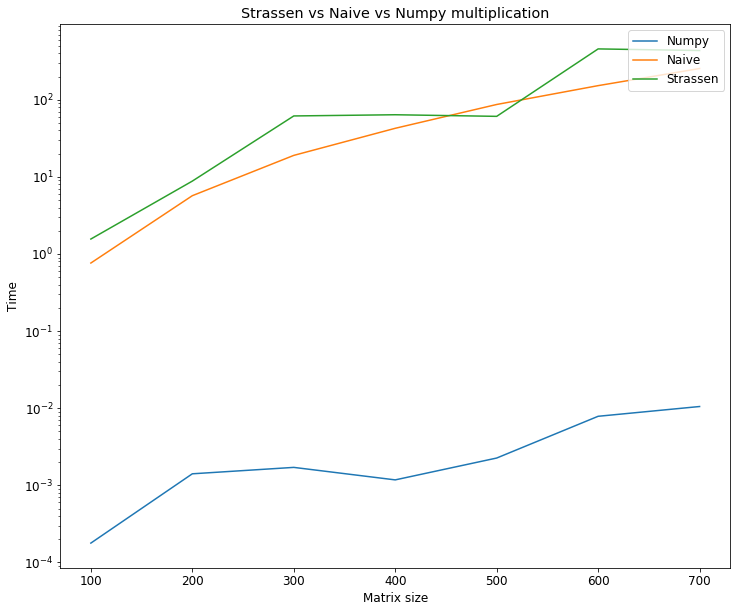

In [336]:
fig = plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 12
plt.plot(matrix_size, numpy_results, label="Numpy")
plt.plot(matrix_size, naive_results, label="Naive")
plt.plot(matrix_size, strassen_results, label="Strassen")
plt.ylabel("Time")
plt.xlabel("Matrix size")
plt.yscale('log')
plt.title("Strassen vs Naive vs Numpy multiplication (log scale)")
plt.legend(loc = "upper right")
plt.show()

#### On the plot above we can see results of comparison different algorithms of matrix multiplication: Strassen, Naive and standart Numpy .dot. This algorithms should behave according to its complexities: Naive ~ $O(n^3)$, Strassen ~ $O(n^{2.8})$. Naive really follows its complexity, numpy.dot has the greatest performance. But there is the issue for Strassen. In general, it works slightly worse than Naive algorithm. There is explanation to this issue. Implementation of Strassen provided here deals with square matrices of any size. If the side of matrix doesn't equal power of 2, algorithm create padding, i.e, adds zeroes to make the size equal power of 2. So, firstly, algorithm waste time just multiplying extra zeroes on each recursive iteration; secondly, it take some time to 'pad' initial matrix on the first iteraton. Actually, for matrix 500x500, when the size is not so far from power of 2 (512), Strassen algorithm really shows better performance than Naive. So, to completely prove this theory let's check performance on matrices with the sides equal power of 2.

In [330]:
import time

matrix_size = np.array([])
numpy_results = np.array([])
naive_results = np.array([])
strassen_results = np.array([])
n = 128

while n < 1025:
    matrix_size = np.append(matrix_size, n)
    
    A = np.random.randn(n, n)
    B = np.random.randn(n, n)
    
    #numpy_score = %timeit -o np.dot(A,B)
    #naive_score = %timeit -o naive_multiplication(A,B)
    #strassen_score = %timeit -o strassen(A,B)
    
    start_numpy = time.time()
    np.dot(A,B)
    finish_numpy = time.time()
    
    start_naive = time.time()    
    naive_multiplication(A,B)
    finish_naive = time.time()
    
    start_stras = time.time()  
    strassen(A,B)
    finish_stras = time.time()    
    
    numpy_results = np.append(numpy_results, finish_numpy - start_numpy)
    naive_results = np.append(naive_results, finish_naive - start_naive)
    strassen_results = np.append(strassen_results, finish_stras - start_stras)
    
    n = n*2
    
    #numpy_results = np.append(numpy_results, np.array(numpy_score.all_runs).sum() / (numpy_score.repeat))
    #naive_results = np.append(naive_results, np.array(naive_score.all_runs).sum() / (naive_score.repeat))
    #strassen_results = np.append(strassen_results, np.array(strassen_score.all_runs).sum() / (strassen_score.repeat))



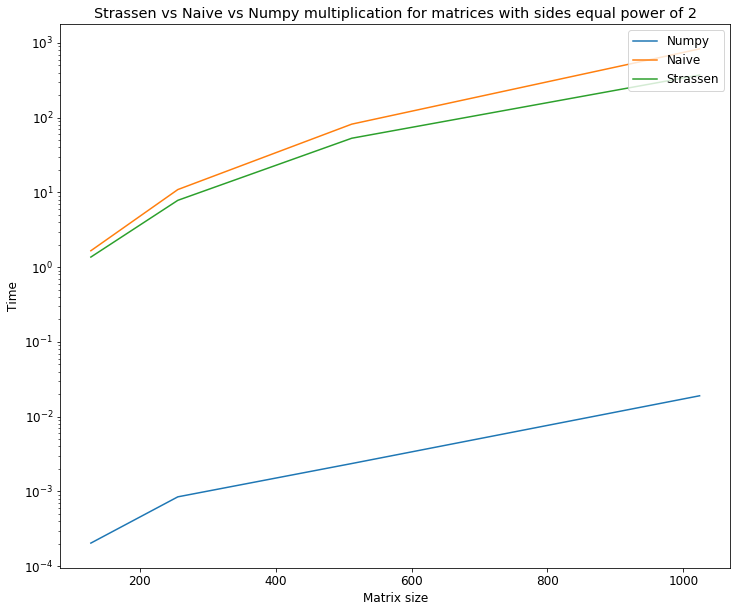

In [334]:
fig = plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 12
plt.plot(matrix_size, numpy_results, label="Numpy")
plt.plot(matrix_size, naive_results, label="Naive")
plt.plot(matrix_size, strassen_results, label="Strassen")
plt.ylabel("Time")
plt.xlabel("Matrix size")
plt.yscale('log')
plt.title("Strassen vs Naive vs Numpy multiplication for matrices with sides equal power of 2 (log scale)")
plt.legend(loc = "upper right")
plt.show()

#### It's clear from this plot that our assumption is proved and algorithms show expected performance according to their complexities: Naive ~ $O(n^3)$, Strassen ~ $O(n^{2.8})$, numpy.dot  still shows the best performance.

# Problem 4 (SVD) 20 pts
In this assignment you are supposed to study how SVD could be used in image compression.

_1._ (2 pts) Compute the singular values of some predownloaded image (via the code provided below) and plot them. Do not forget to use logarithmic scale.

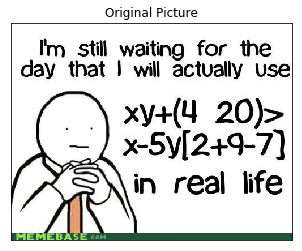

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import numpy as np


#url = 'https://pbs.twimg.com/profile_images/1658625695/my_photo_400x400.jpg'  # Ivan
url = 'https://i.chzbgr.com/full/5536320768/h88BAB406/' # Insight
# url = 'https://cdn.pixabay.com/photo/2013/06/29/21/18/wolf-142173_1280.jpg' # your favorite picture, please!

face_raw = Image.open(requests.get(url, stream=True).raw)
face = np.array(face_raw).astype(np.uint8)

plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title('Original Picture')
plt.show()

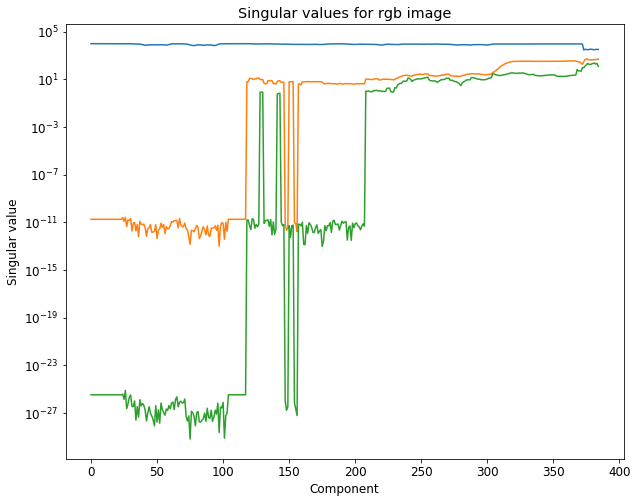

In [198]:
u, s, vh = np.linalg.svd(face)

fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.plot(s)
plt.ylabel("Singular value")
plt.xlabel("Component")
plt.yscale('log')
plt.title("Singular values for rgb image (log scale)")
plt.show()

_2._ (3 pts) Complete a function ```compress```, that performs SVD and truncates it (using $k$ singular values/vectors). See the prototype below. 

Note, that in colourful case you have to split your image to channels and work with matrices corresponding to different channels separately.

Plot approximate reconstructed image $M_\varepsilon$ of your favorite image such that $rank(M_\varepsilon) = 5, 20, 50$ using ```plt.subplots```.

In [282]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    def compress_channel(img_channel, k):
        u, s, vh = np.linalg.svd(img_channel, full_matrices=False)
        reconst_matrix = u[:,:k] @ (np.diag(s[:k]) @ vh[:k,:])
        return reconst_matrix, s
    
    # Habdle gray scale images
    if (len(image.shape) < 3):
        return compress_channel(image, k)
    
    compressed_channels = [compress_channel(image[:,:,i], k)[0] for i in range(3)]
    
    initial_shape = image.shape
    reconst_matrix = np.zeros(initial_shape)

    for i in range(3):
        reconst_matrix[:,:,i] = compressed_channels[i]
    
    ,s, = np.linalg.svd(img_channel, full_matrices=False)

    return reconst_matrix, s

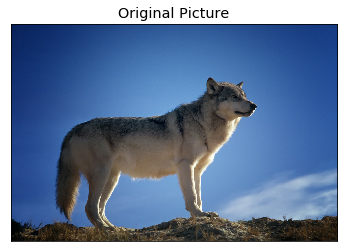

In [317]:
url = 'https://cdn.pixabay.com/photo/2013/06/29/21/18/wolf-142173_1280.jpg'

face_raw = Image.open(requests.get(url, stream=True).raw)
face = np.array(face_raw).astype(np.uint8)

plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title('Original Picture')
plt.show()

In [318]:
img_r5, s = compress(face, 5)
img_r20, s = compress(face, 20)
img_r50, s = compress(face, 50)

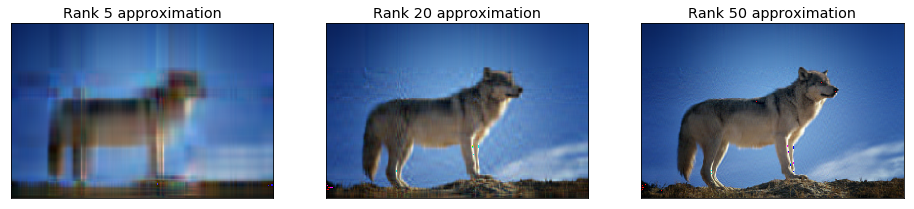

In [319]:
img_r5 = np.array(img_r5).astype(np.uint8)
img_r20 = np.array(img_r20).astype(np.uint8)
img_r50 = np.array(img_r50).astype(np.uint8)

fig = plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(img_r5)
plt.title('Rank 5 approximation')
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
plt.imshow(img_r20)
plt.title('Rank 20 approximation')
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 3)
plt.imshow(img_r50)
plt.title('Rank 50 approximation')
plt.xticks(())
plt.yticks(())
plt.show()

_3._ (3 pts) Plot the following two figures for your favorite picture
* How relative error of approximation depends on the rank of approximation?
* How compression rate in terms of storing information ((singular vectors + singular numbers) / total size of image) depends on the rank of approximation?

In [307]:
def calculate_relative_error(image, k):
    compressed, s = compress(image, k)
    Ar0 = compressed[:,:,0]
    Ar1 = compressed[:,:,1]
    Ar2 = compressed[:,:,2]
    
    A = image
    
    rel_err_r = np.linalg.norm((A[:,:,0] - Ar0) ,ord=2)
    rel_err_g = np.linalg.norm((A[:,:,1] - Ar1) ,ord=2)
    rel_err_b = np.linalg.norm((A[:,:,2] - Ar2) ,ord=2)
    
    return rel_err_r, rel_err_g, rel_err_b

def compression_rate(image, k):
    original_shape = image.shape
    m = original_shape[0]
    n = original_shape[1]
    
    compress_ratio = (k*(m + n) + k)/(m*n)
    
    return compress_ratio


In [308]:
rel_error_0 = np.array([])
rel_error_1 = np.array([])
rel_error_2 = np.array([])
compress_rate = np.array([])
rank = [k for k in range (100)]

for k in range (50):
    rel_err_0, rel_err_1, rel_err_2 = calculate_relative_error(face, k)
    compress_ratio = compression_rate(face, k)
    rel_error_0 = np.append(rel_error_0, rel_err_0)
    rel_error_1 = np.append(rel_error_1, rel_err_1)
    rel_error_2 = np.append(rel_error_2, rel_err_2)
    compress_rate = np.append(compress_rate, compress_ratio)

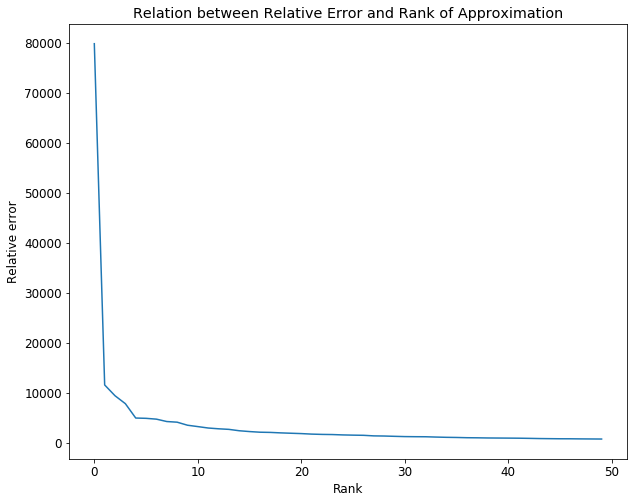

In [309]:
fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.plot(rel_error_0)
plt.ylabel("Relative error")
plt.xlabel("Rank")
plt.title("Relation between Relative Error and Rank of Approximation")
plt.show()

#### If we choose bigger value of approximato's rank, we approximate original image with bigger amount of singular vectors and singulal values. So approximation becomes better with the increase of the rank.

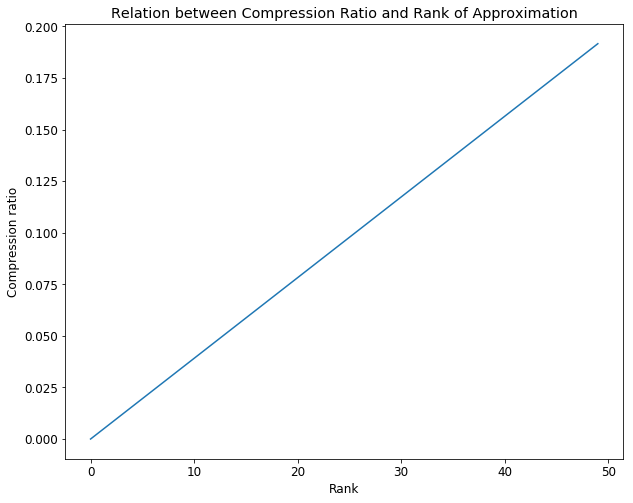

In [299]:
fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.plot(compress_rate)
plt.ylabel("Compression ratio")
plt.xlabel("Rank")
plt.title("Relation between Compression Ratio and Rank of Approximation")
plt.show()

#### Compression rate increases linearly with increase of approximation's rank (it is clear from calculations in compression_rate() function). The bigger rank we choose for approximation the bigger amount of information (singular vectors and singular values) we store.

_4._ (2 pts) Consider the following two pictures. Compute their approximations (with the same rank, or relative error). What do you see? Explain results.

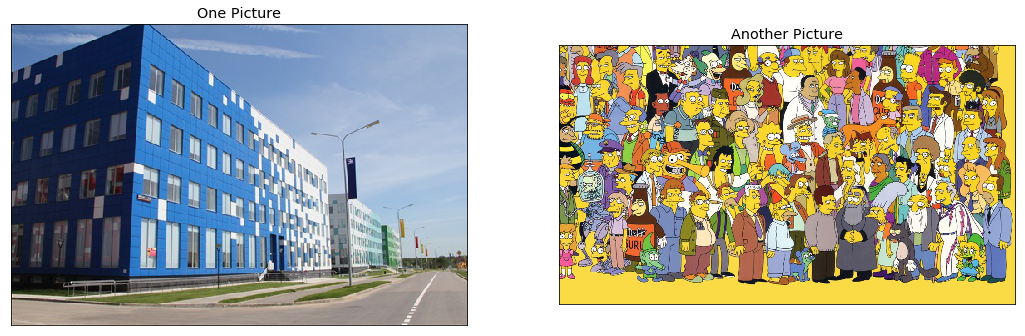

In [316]:
url1 = 'http://sk.ru/resized-image.ashx/__size/550x0/__key/communityserver-blogs-components-weblogfiles/00-00-00-60-11/skoltech1.jpg'
url2 = 'http://www.simpsoncrazy.com/content/characters/poster/bottom-right.jpg'
image_raw1 = Image.open(requests.get(url1, stream=True).raw)
image_raw2 = Image.open(requests.get(url2, stream=True).raw)

image1 = np.array(image_raw1).astype(np.uint8)
image2 = np.array(image_raw2).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.imshow(image_raw1)
plt.title('One Picture')
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(image_raw2)
plt.title('Another Picture')
plt.xticks(())
plt.yticks(())

plt.show()

In [228]:
img1_raw, s1 = compress(image1, 100)
img2_raw, s2 = compress(image2, 100)

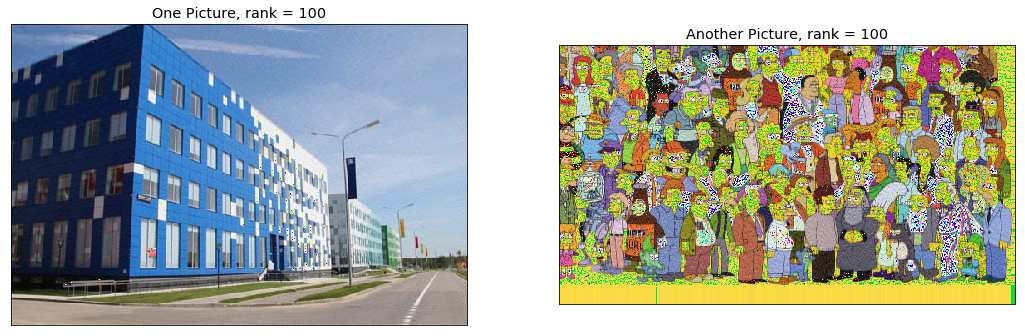

In [231]:
img1 = np.array(img1_raw).astype(np.uint8)
img2 = np.array(img2_raw).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('One Picture, rank = 100')
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Another Picture, rank = 100')
plt.xticks(())
plt.yticks(())

plt.show()

#### The right picture's (with simpsons) compression is worse then the left picture in terms of picture's quality. It happens because there are many colors and strict boundaries between colors and items on the right picture. So, it is needed to store more "information" (in terms of singular values and vectors) about the right picture, i.e. if one wants to get more clear right picture, it is needed to use bigger rank of approximation. 

# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```